In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dag_prf_utils.plot_functions import *
%matplotlib inline

import tensorflow as tf
tf.config.list_physical_devices('GPU')

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
Error importing pycortex... Not a problem unless you want to use pycortex stuff
SUBJECTS_DIR not found in os.environ
Adding empty string...


[]

In [2]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))

In [3]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':1,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [4]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [5]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))

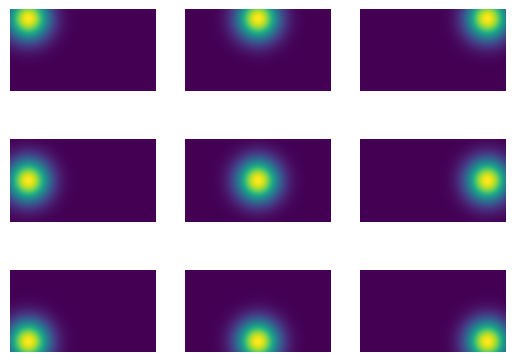

In [6]:
for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

<Axes: xlabel='frame'>

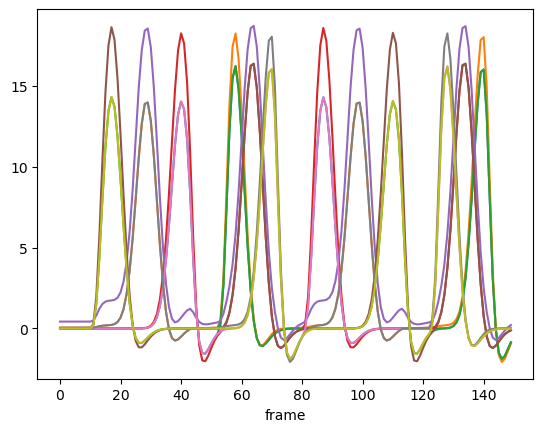

In [7]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

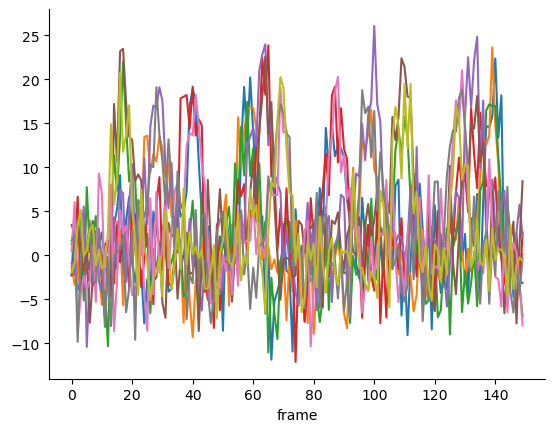

In [8]:
data = model.simulate(noise=4)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [9]:
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
cfitter = ParameterFitter(model, data, paradigm)


grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)

Working with chunk size of 493827
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.66339/Best R2: 0.66339:  18%|█▊        | 185/1000 [00:02<00:09, 86.20it/s] 


parameter         x        y        sd  baseline  amplitude
0         -0.743429 -0.40855  0.162021  0.131517   1.067621


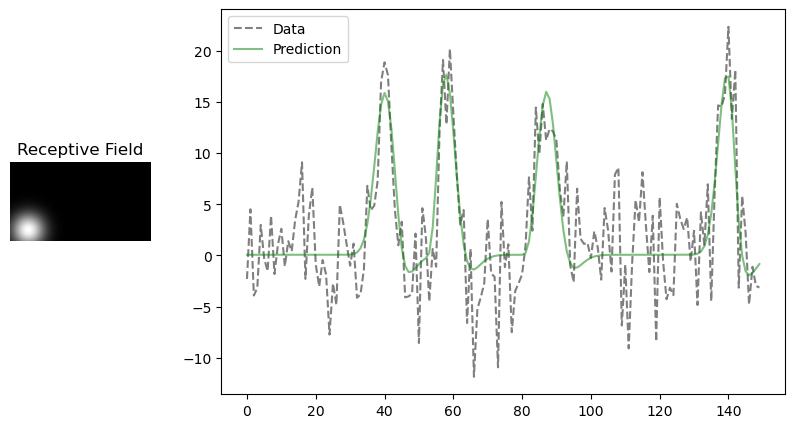

In [11]:
idx = 0
from braincoder.utils.visualize import quick_plot
quick_plot(
    model=model, 
    parameters=refined_pars.iloc[idx,:],
    data=data.iloc[:,idx]

)

# MCMC Gaussian

In [12]:
bounds = {
    'x' : [-1, 1],
    'y' : [-1, 1],
    'sd' : [0, 10],
    'baseline' : [0,0],
    'amplitude' : [0, 10], 
}

n_vx = parameters.shape[0]
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),
})
bfitter = BPRF(model=model, data=data, )
bfitter.add_priors_from_bounds(bounds,) 
bfitter.prep_for_fitting()

bfitterL = BPRF(model=model, data=data, )
bfitterL.add_priors_from_bounds(bounds,prior_type='latent_uniform')
bfitterL.prep_for_fitting()

NOT WORKING YET
NOT WORKING YET


In [13]:
idx = 0
num_results = 20
bfitter.fit(
    idx=idx,
    init_pars=init_pars,
    num_results=num_results,         
)

bfitterL.fit(
    idx=idx,
    init_pars=init_pars,
    num_results=num_results,         
)

tf.Tensor([-4448.879], shape=(1,), dtype=float32)
tf.Tensor([-5310.254], shape=(1,), dtype=float32)


In [14]:
bloop

NameError: name 'bloop' is not defined

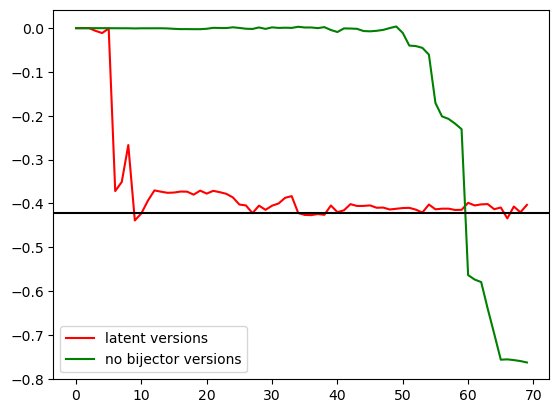

In [21]:
# Lets compare...
p = 'y'
plt.plot(
    bfitterL.mcmc_sampler[idx][p],
    color='r', label='latent versions')
plt.plot(
    bfitter.mcmc_sampler[idx][p],
    color='g', label='no bijector versions')
plt.axhline(
    parameters[p][idx], color='k'
)
plt.legend()

In [81]:
bfitterL.mcmc_sampler[idx]

,x,y,sd,baseline,amplitude
0,0.0,0.0,NaN,0.0,NaN
1,0.0,0.0,NaN,0.0,NaN
2,0.0,0.0,NaN,0.0,NaN
3,0.0,0.0,NaN,0.0,NaN
4,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...
245,0.0,0.0,NaN,0.0,NaN
246,0.0,0.0,NaN,0.0,NaN
247,0.0,0.0,NaN,0.0,NaN
248,0.0,0.0,NaN,0.0,NaN


In [99]:
rsq = bfitter.get_rsq_for_idx(
    idx=idx, parameters=bfitter.mcmc_sampler[idx],
)

rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )

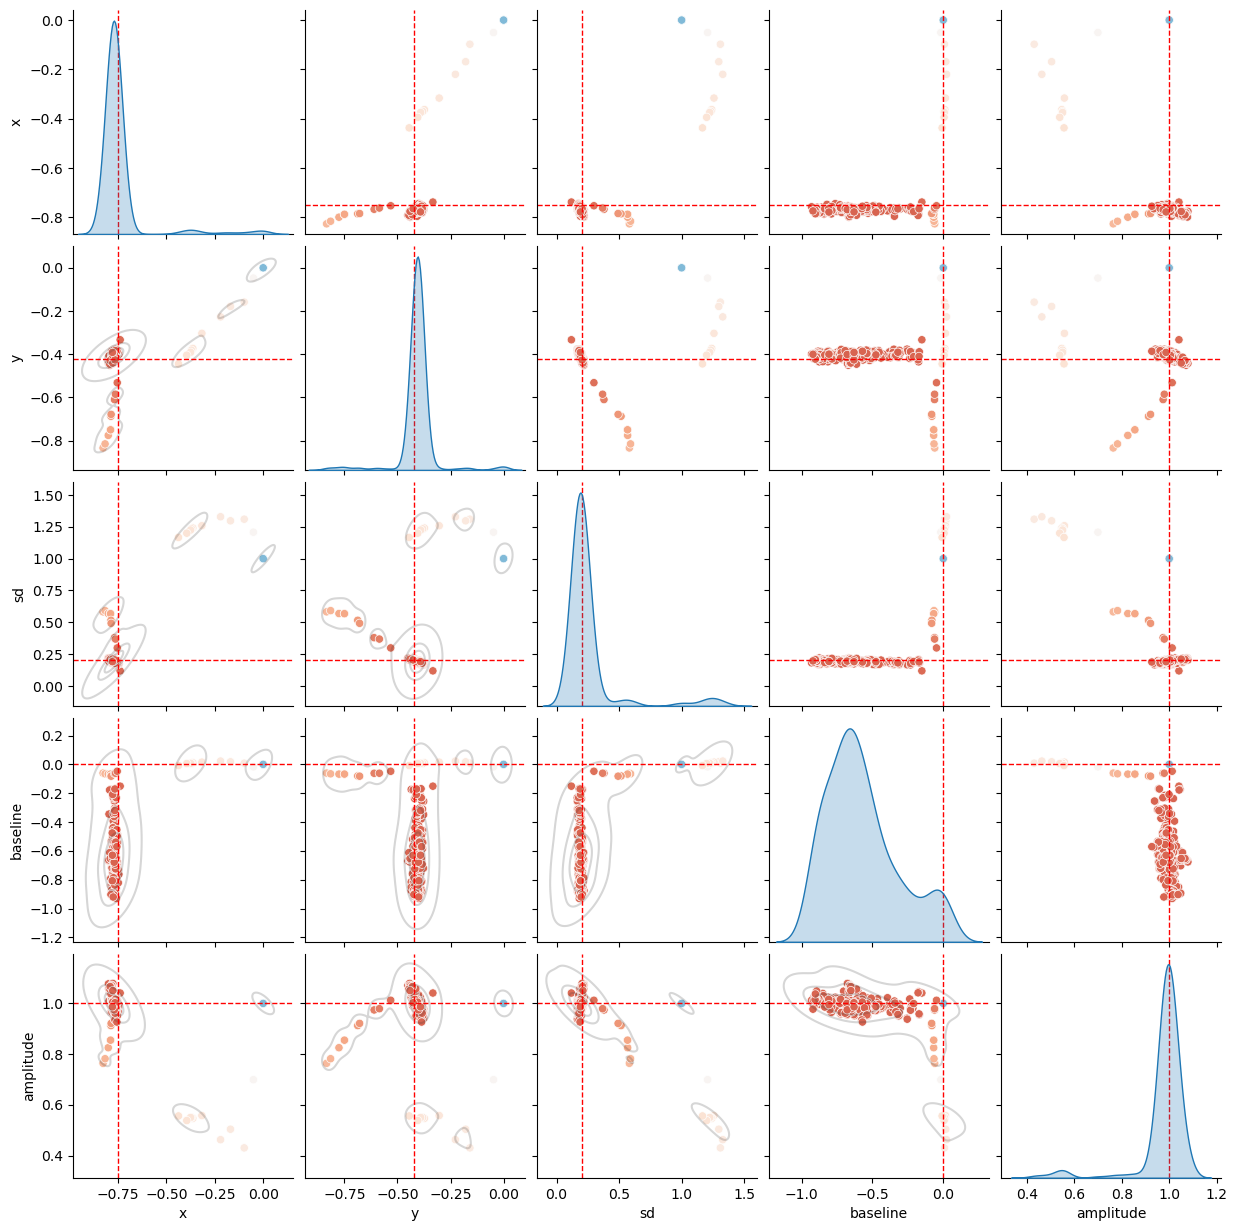

In [ ]:
idx = 0
burn_in = 0
sns_plot = sns.pairplot(
    bfitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.
add_lines_to_pairplot(
    sns_plot.axes, parameters.iloc[idx,:].to_dict()
)
plt.show()

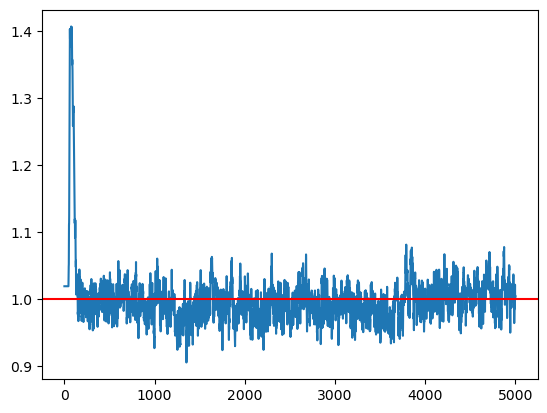

In [47]:
p = 'amplitude'
plt.plot(bfitter.mcmc_sampler[idx][p])
plt.axhline(parameters.iloc[idx][p], c='r')

# Mexican hat model

In [17]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

<Axes: xlabel='frame'>

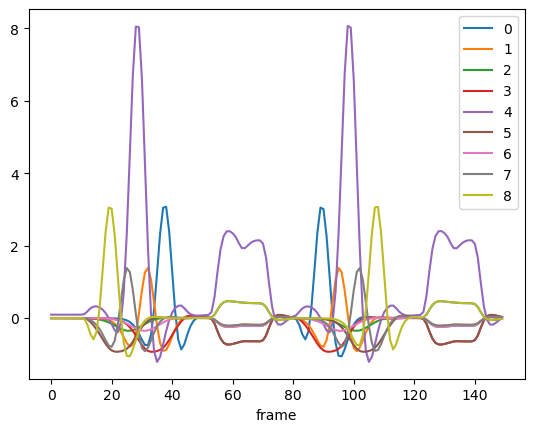

In [ ]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.3,
               'baseline':0.0,
               'srf_amplitude':.5, 
               'srf_size':2}).astype(np.float32)
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))
pred_dog = model_dog.predict()
pred_dog.plot()

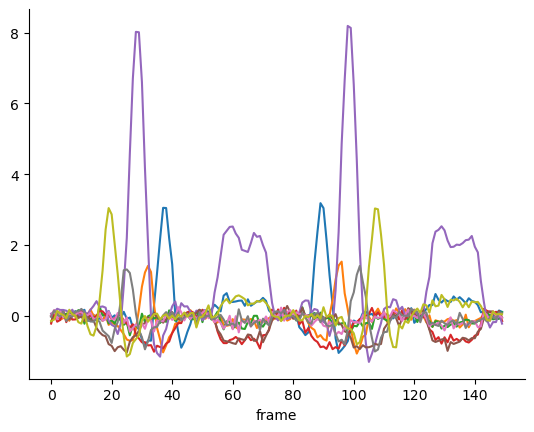

In [ ]:
data_dog = model_dog.simulate(noise=.1)
data_dog.plot(legend=False)
sns.despine()

In [20]:
fitter_dog = ParameterFitter(model_dog, data_dog, paradigm)

In [21]:
init_pars_dog = refined_pars.copy()
init_pars_dog['srf_amplitude'] = 0.1
init_pars_dog['srf_size'] = 2.

In [22]:
est_pars_dog = fitter_dog.fit(
    init_pars=init_pars_dog, learning_rate=0.001,
    max_n_iterations=1000,
    )

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.81478/Best R2: 0.81478:  36%|███▌      | 360/1000 [00:04<00:07, 81.77it/s]   


KeyboardInterrupt: 

parameter
x               -0.803353
y               -0.365886
sd               0.153725
baseline        -0.002035
amplitude        0.954807
srf_amplitude    0.151359
srf_size         2.130490
Name: 0, dtype: float32
x               -0.750000
y               -0.421875
sd               0.200000
amplitude        0.300000
baseline         0.000000
srf_amplitude    0.500000
srf_size         2.000000
Name: 0, dtype: float32


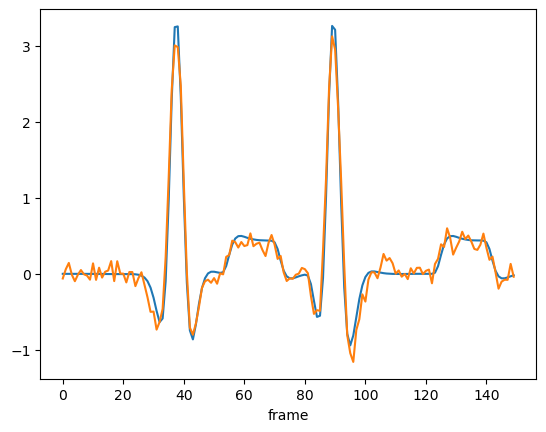

In [56]:
idx = 0
est_pred = model_dog.predict(parameters=est_pars_dog)
est_pred[idx].plot()
data_dog[idx].plot()
print(est_pars_dog.iloc[idx,:])
print(parameters_dog.iloc[idx,:])


# MCMC - DOG

In [57]:
bounds_dog = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'sd' : [0, 10],
    'baseline' : [-2,2],
    'amplitude' : [0,100], 
    'srf_amplitude': [0, 10],
    'srf_size' : [1, 10],

}

n_vx = parameters_dog.shape[0]
# init_pars_dog = pd.DataFrame({    
#     'x' : np.zeros(n_vx),
#     'y' : np.zeros(n_vx),
#     'sd' : np.zeros(n_vx),
#     'baseline' : np.zeros(n_vx),
#     'amplitude' : np.zeros(n_vx),
#     'srf_amplitude' : np.zeros(n_vx),
#     'srf_size' : np.zeros(n_vx),

# })
bfitter_dog = BPRF(model=model_dog, data=data_dog, )
bfitter_dog.add_priors_from_bounds(bounds_dog, prior_type='latent_uniform')
bfitter_dog.prep_for_fitting()

In [62]:
bfitter_dog.fit(
    idx=[0,], #2,3], 
    init_pars=init_pars_dog,
    num_results=500,         
    kernel_type='braincoder',
)

tf.Tensor([-1547.6807], shape=(1,), dtype=float32)


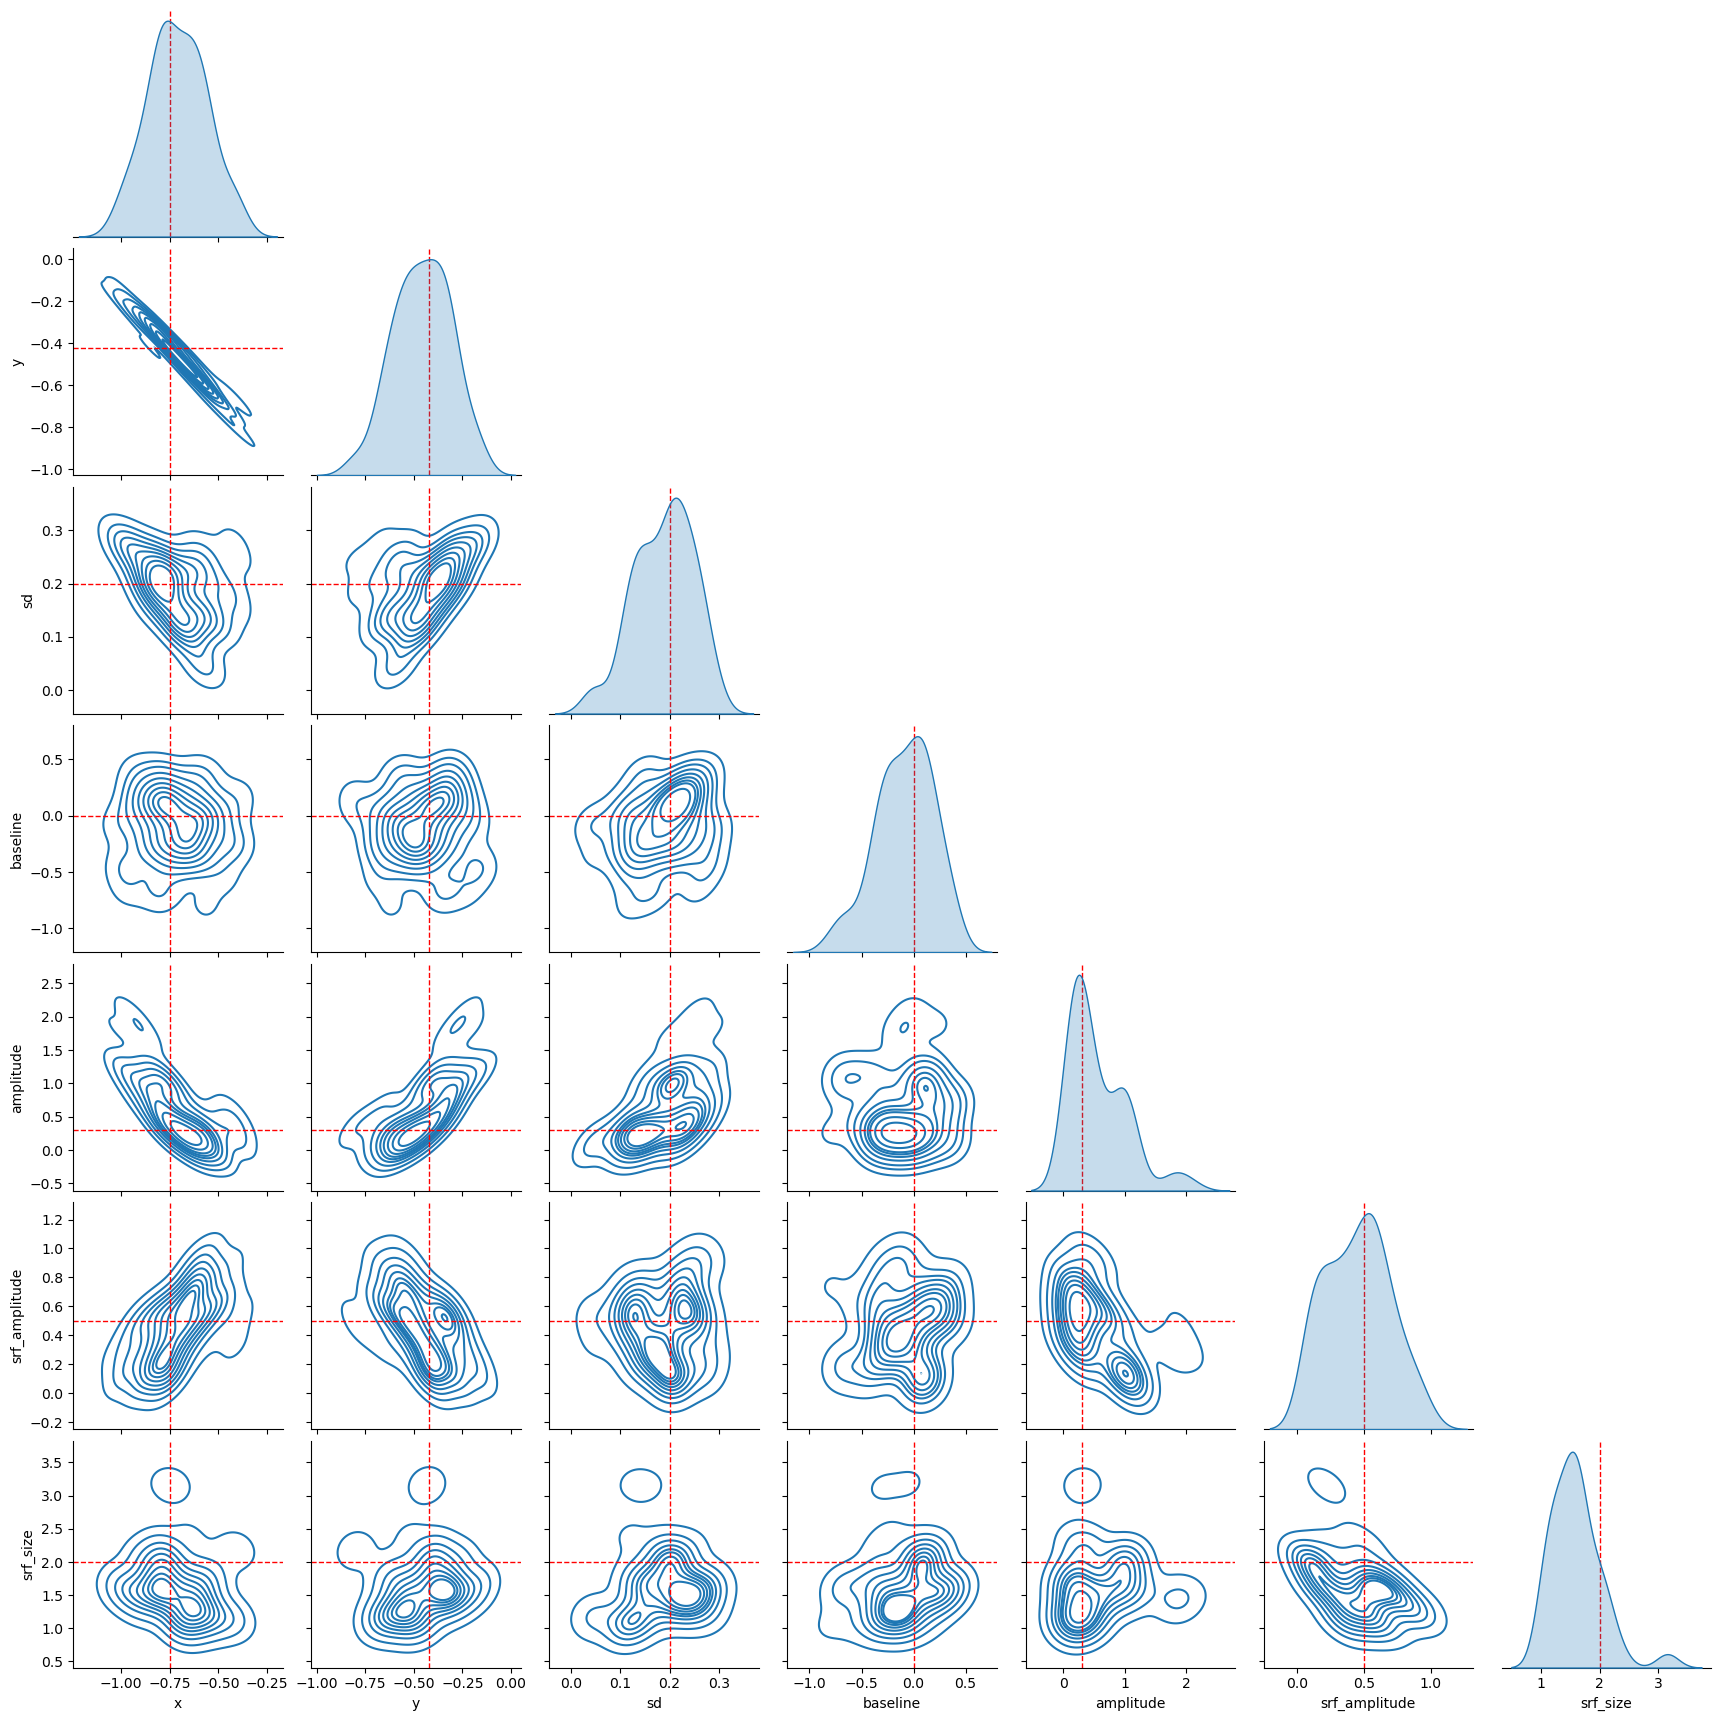

In [61]:
idx = 0
sns_plot = sns.pairplot(
    bfitter_dog.mcmc_sampler[idx],
    corner=True,kind='kde'
)
add_lines_to_pairplot(
    sns_plot.axes, parameters_dog.iloc[idx,:].to_dict()
)
plt.show()

In [27]:
bfitter_dog.mcmc_sampler[idx].shape

(70, 7)

In [45]:
bfitter_dog.mcmc_sampler[0].x

0    -0.75186
1    -0.75186
2    -0.75186
3    -0.75186
4    -0.75186
       ...   
65   -0.75186
66   -0.75186
67   -0.75186
68   -0.75186
69   -0.75186
Name: x, Length: 70, dtype: float32